In [1]:
import numpy as np
import pandas as pd
import librosa
import time
import matplotlib.pyplot as plt
import h5py

from glob import glob
from tqdm import tqdm
import os
import re
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.compat.v1.keras.backend import set_session, clear_session, get_session
import gc

import Networks


Only fully connected layer regularized

In [2]:
# Load saved segments
def Load_Segments(dataset, fold):
    
    if dataset=='ESC10':
        if fold==1:
            hf = h5py.File('ESC10/MF1.h5', 'r')    
        if fold==2:
            hf = h5py.File('ESC10/MF2.h5', 'r')
        if fold==3:
            hf = h5py.File('ESC10/MF3.h5', 'r')
        if fold==4:
            hf = h5py.File('ESC10/MF4.h5', 'r')
        if fold==5:
            hf = h5py.File('ESC10/MF5.h5', 'r')

    if dataset=='ESC50':
        if fold==1:
            hf = h5py.File('ESC50/AMF1.h5', 'r')    
        if fold==2:
            hf = h5py.File('ESC50/AMF2.h5', 'r')
        if fold==3:
            hf = h5py.File('ESC50/AMF3.h5', 'r')
        if fold==4:
            hf = h5py.File('ESC50/AMF4.h5', 'r')
        if fold==5:
            hf = h5py.File('ESC50/AMF5.h5', 'r')
    
    # Get training
    train_d = np.array(hf.get('train_data'))
    train_l = np.array(hf.get('train_label'))


    # Get validation
    val_d = np.array(hf.get('validation_data'))
    val_l = np.array(hf.get('validation_label'))

    # Get test
    test_d = np.array(hf.get('test_data'))
    test_l = np.array(hf.get('test_label'))

    hf.close()
    
    # Cast to float32
    train_d = np.asarray(train_d, dtype=np.float32)
    train_l = np.asarray(train_l, dtype=np.float32)
    
    val_d = np.asarray(val_d, dtype=np.float32)
    val_l = np.asarray(val_l, dtype=np.float32)
    
    test_d = np.asarray(test_d, dtype=np.float32)
    test_l = np.asarray(test_l, dtype=np.float32)
    
    return train_d, train_l, val_d, val_l, test_d, test_l


def CreateTrainingSet10(data, label, batch_size=32):
    
    # Shuffle the folds
    rnd_indices = np.arange(0, len(data))
    rnd_indices = np.random.shuffle(rnd_indices)
    
    data = data[rnd_indices].reshape((len(data), 60, 41, 3))
    label = label[rnd_indices].reshape((len(label), 10))
    
    
    data = data.astype(np.float32)
    label = label.astype(np.float32)
    
    '''
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0,
                                                              height_shift_range=0,
                                                              horizontal_flip=False,
                                                              vertical_flip=False) 
    
    # Shuffle all elements at every iteration
    training_dataset = datagen.flow(data, label, batch_size=batch_size, shuffle=True)
    '''
    
    training_dataset = tf.data.Dataset.from_tensor_slices((data, label))
    
    # Shuffle all elements at every iteration
    training_dataset = training_dataset.shuffle(len(training_dataset))
    
    # Define batch_size and prefetch size
    training_dataset = training_dataset.batch(batch_size=batch_size).prefetch(buffer_size=1)
    
    return training_dataset


def CreateTrainingSet50(data, label, batch_size=32):
    
    # Shuffle the folds
    rnd_indices = np.arange(0, len(data))
    rnd_indices = np.random.shuffle(rnd_indices)
    
    data = data[rnd_indices].reshape((len(data), 60, 41, 3))
    label = label[rnd_indices].reshape((len(label), 50))
    
    
    data = data.astype(np.float32)
    label = label.astype(np.float32)
    
    '''
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0,
                                                              height_shift_range=0,
                                                              horizontal_flip=False,
                                                              vertical_flip=False) 
    
    # Shuffle all elements at every iteration
    training_dataset = datagen.flow(data, label, batch_size=batch_size, shuffle=True)
    '''
    
    training_dataset = tf.data.Dataset.from_tensor_slices((data, label))
    
    # Shuffle all elements at every iteration
    training_dataset = training_dataset.shuffle(len(training_dataset))
    
    # Define batch_size and prefetch size
    training_dataset = training_dataset.batch(batch_size=batch_size).prefetch(buffer_size=1)
    
    return training_dataset


def CreateValidationSet(data, label, batch_size=32):
    
    data = data.astype(dtype=np.float32)
    label = label.astype(dtype=np.float32)
    
    # Create and cache training
    validation_dataset = tf.data.Dataset.from_tensor_slices((data, label))
    
    # Cache dataset
    #validation_dataset = validation_dataset.cache(name)
    
    # Define batch_size and prefetch size
    validation_dataset = validation_dataset.batch(batch_size=batch_size).prefetch(buffer_size=1)
    
    return validation_dataset


def train(net, max_epochs, training_dataset, validation_dataset, verbose=True):
    
    epoch_loss= []
    epoch_acc = []

    epoch_vl = []
    epoch_va = []

    # Loop over the epochs
    for epoch in range(max_epochs):


        step_loss = []
        step_acc = []

        step_vl = []
        step_va = []

        batches = 0
        start = time.time()
        # train over mini-batches
        for x_batch, y_batch in training_dataset:

            # train on batch
            step_stats = net.train_on_batch(x_batch, y_batch)

            # save loss and accuracy
            step_loss.append(step_stats[0])
            step_acc.append(step_stats[1])


        # compute validation stats
        for x_batch, y_batch in validation_dataset:

            # compute validation stats
            val_stats = net.test_on_batch(x_batch, y_batch)

            # save loss and accuracy
            step_vl.append(val_stats[0])
            step_va.append(val_stats[1])


        end = time.time()

        # Save the mean loss and accuracy of the entire epoch
        epoch_loss.append(np.mean(step_loss))
        epoch_acc.append(np.mean(step_acc))
        epoch_vl.append(np.mean(step_vl))
        epoch_va.append(np.mean(step_va))

        # Print epoch training stats
        if verbose:
            print("Epoch %2d: \t t-loss: %3.6f \t t-acc: %.6f \t v-loss: %3.6f \t v-acc: %.6f \t time: %3.3f" % (epoch + 1, epoch_loss[-1], epoch_acc[-1], epoch_vl[-1], epoch_va[-1], (end - start)))
        
    return epoch_loss, epoch_acc, epoch_vl, epoch_va
    
    
# Reset Keras Session
def reset_keras():
    
    # Get and close session
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()
    
    # Garbage collector call
    gc.collect()
    
    # Init new session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tf.compat.v1.Session(config=config))

## Final Training

In [4]:
# Define training parameters
max_epochs = 60
batch_size = 256
lr = 0.002

# load the fold data
train_d, train_l, val_d, val_l, test_d, test_l = Load_Segments('ESC50', 1)

# Add validation to training
train_d = np.concatenate((train_d, val_d))
train_l = np.concatenate((train_l, val_l))

# Generate training
training_dataset = CreateTrainingSet50(train_d, train_l, batch_size=batch_size)

# Initialize the network
net = Networks.MFNetReg50([60, 41, 3])
loss_f = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
opt = tf.keras.optimizers.SGD(lr=lr, momentum=0.9, nesterov=True)
net.compile(optimizer=opt, loss=loss_f, metrics=["accuracy"])

In [5]:
epoch_loss= []
epoch_acc = []

# Loop over the epochs
for epoch in range(max_epochs):


    step_loss = []
    step_acc = []

    batches = 0
    start = time.time()
    # train over mini-batches
    for x_batch, y_batch in training_dataset:

        # train on batch
        step_stats = net.train_on_batch(x_batch, y_batch)

        # save loss and accuracy
        step_loss.append(step_stats[0])
        step_acc.append(step_stats[1])

    end = time.time()

    # Save the mean loss and accuracy of the entire epoch
    epoch_loss.append(np.mean(step_loss))
    epoch_acc.append(np.mean(step_acc))

    # Print epoch training stats
    print("Epoch %2d: \t t-loss: %3.6f \t t-acc: %.6f \t time: %3.3f" % (epoch + 1, epoch_loss[-1], epoch_acc[-1], (end - start)))

Epoch  1: 	 t-loss: 13.947832 	 t-acc: 0.129768 	 time: 45.818
Epoch  2: 	 t-loss: 12.959271 	 t-acc: 0.307397 	 time: 40.929
Epoch  3: 	 t-loss: 12.292497 	 t-acc: 0.448956 	 time: 40.679
Epoch  4: 	 t-loss: 11.825911 	 t-acc: 0.543617 	 time: 41.113
Epoch  5: 	 t-loss: 11.471987 	 t-acc: 0.615067 	 time: 40.823
Epoch  6: 	 t-loss: 11.179049 	 t-acc: 0.668509 	 time: 40.427
Epoch  7: 	 t-loss: 10.922270 	 t-acc: 0.708391 	 time: 40.499
Epoch  8: 	 t-loss: 10.704292 	 t-acc: 0.743048 	 time: 40.668
Epoch  9: 	 t-loss: 10.487422 	 t-acc: 0.774731 	 time: 40.579
Epoch 10: 	 t-loss: 10.301348 	 t-acc: 0.799044 	 time: 40.619
Epoch 11: 	 t-loss: 10.131253 	 t-acc: 0.818918 	 time: 40.298
Epoch 12: 	 t-loss: 9.964501 	 t-acc: 0.836072 	 time: 40.670
Epoch 13: 	 t-loss: 9.810325 	 t-acc: 0.851310 	 time: 40.488
Epoch 14: 	 t-loss: 9.662024 	 t-acc: 0.866696 	 time: 40.375
Epoch 15: 	 t-loss: 9.523442 	 t-acc: 0.875869 	 time: 40.405
Epoch 16: 	 t-loss: 9.387743 	 t-acc: 0.888759 	 time: 40.8

## Test Model

In [6]:
_, test_accuracy = net.evaluate(test_d, test_l)

print('\nTest set segment accuracy: ', test_accuracy)

204/204 [==============================] - 5s 27ms/step - loss: 8.1507 - accuracy: 0.4929

Test set segment accuracy:  0.49286919832229614


## Confusion Matrix

In [17]:
# Label prediction
predicted_label = net.predict(test_d)

# Convert one-hot encoded label back to class identifier
test_label_classes = np.argmax(test_l, axis=1)
predicted_label_classes = np.argmax(predicted_label, axis=1)

# coompute confusion matrix
confusion_matrix = tf.math.confusion_matrix(test_label_classes, predicted_label_classes, num_classes=50)

In [18]:
# Get classes name
df = pd.read_csv(glob('meta/esc50.csv')[0])
df = df[['target','category']]
df = df.drop_duplicates().reset_index(drop=True)
df = df.sort_values(by=['target']).reset_index(drop=True)


classes_dict = {}
for i in range(len(df)):
    classes_dict[df['target'][i]] = df['category'][i]
    
classes = []
for i in range(50):
    classes.append(classes_dict[i])

<AxesSubplot:>

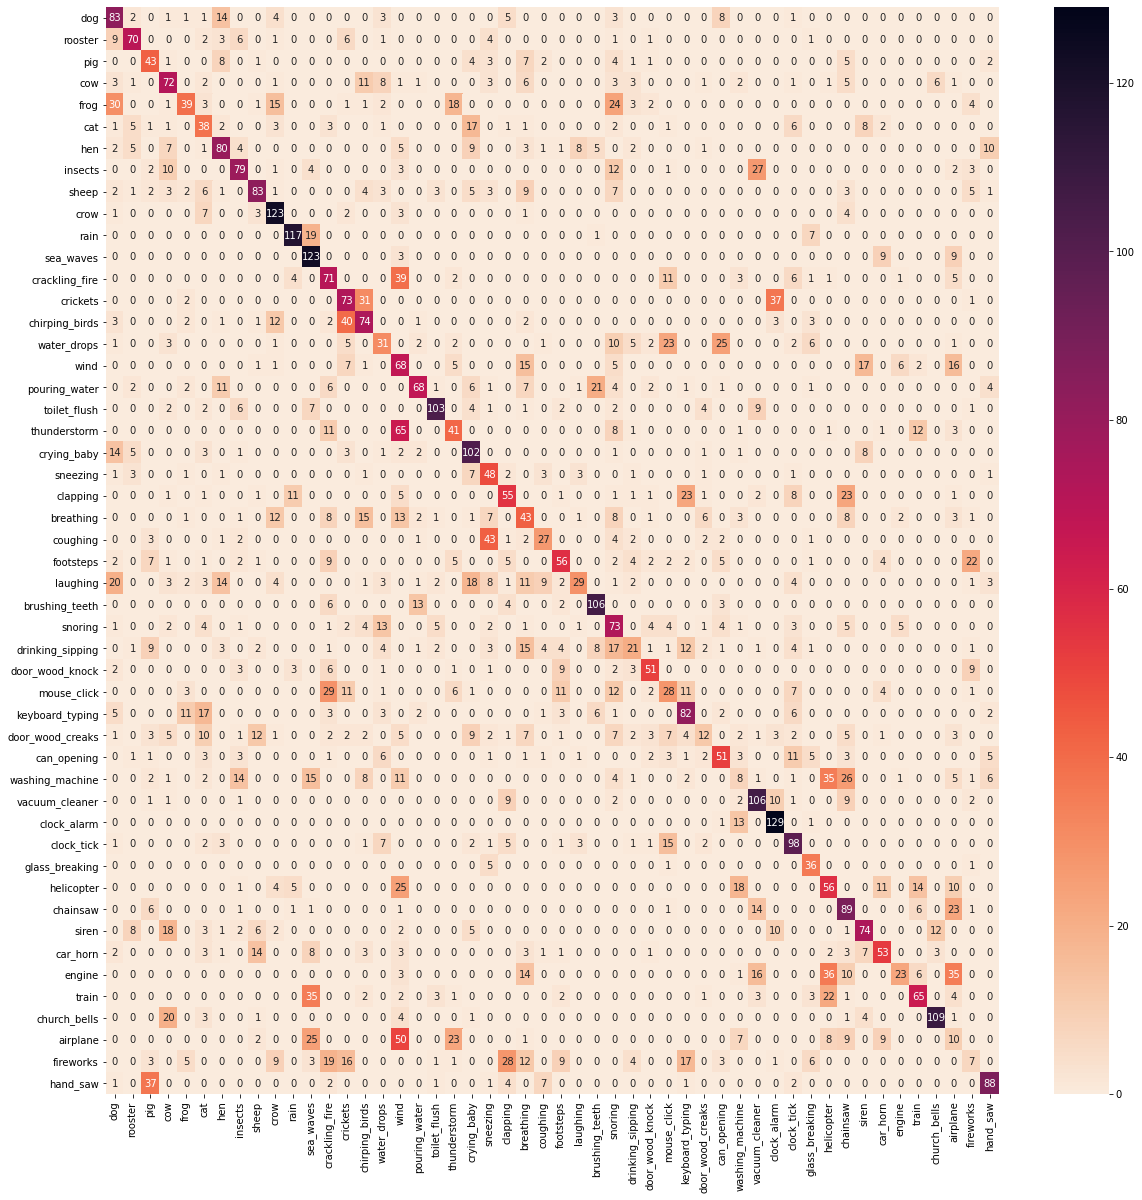

In [19]:
import seaborn as sn

confusion_matrix = confusion_matrix.numpy()

df = pd.DataFrame(confusion_matrix, index=classes, columns=classes)
plt.figure(figsize=(20, 20))
sn.heatmap(df, annot=True, fmt='d', cmap='rocket_r')

## Accuracy on Clip

In [2]:
# Load raw data
def Load_RAW(path):
    '''
        Input:
            path: folder of the dataset
        
        Output:
            raw_data:  list that contains the raw data
            cvs:       list that contains the cross-fold number
            labels:    list that contains the category information
    '''
    
    # Container for the dataset
    raw_data = []
    cvs = []
    labels = []
    # Load every file inside the folder
    for file_name in tqdm(os.listdir(path)):

        try:
            # Get audio data and sampling rate
            audio, sampling_rate = librosa.load(os.path.join(path, file_name), res_type='kaiser_fast')
            # Split the file name
            name_splitted = re.split('[-.]', file_name)
            
            # Append a row of 3 elements
            raw_data.append(audio)
            cvs.append(name_splitted[0])
            labels.append(name_splitted[3])
        except Exception as e:
            pass
    
    # Convert to numpy array
    raw_audio = np.asarray(raw_data)
    cvs = np.asarray(cvs, dtype=int)
    labels = np.asarray(labels, dtype=int)
    
    # onehot encode the labels in 50 classes
    onehot_labels = to_categorical(labels, num_classes=50)
    
    return raw_audio, cvs, onehot_labels

# Split dataset into data and labels
def Split_Data_Label(dataset):
    
    
    data = []
    label = []
        
    for i in range (len(dataset)):
        data.append(dataset[i][0])
        label.append(dataset[i][1])

    
    data = np.asarray(data)
    label = np.asarray(label)
    
    return data, label

def Merge_Data_Label(raw_audio, labels):
    
    dataset = []
    # Loop over each file audio
    for num, audio in enumerate(tqdm(raw_audio)):

        dataset.append((audio, labels[num]))

    
    # Convert to numpy array
    dataset = np.asarray(dataset, dtype=object)
    
    return dataset

def label_map(label):
    
    unique = np.unique(label)
    new_labels = np.arange(0, len(unique))
    
    for i in range(len(unique)):
        
        comp = unique[i]
        
        for k in range(len(label)):
            if label[k] == comp:
                label[k] = new_labels[i]
    
    return label

def Split_Segments(dataset, overlap=0.75, wnd=20480, threshold=10**-6):
    
    data, label = Split_Data_Label(dataset)

    segment_list = []
    label_list = []
    
    # Loop over audio sample
    for num, audio in enumerate(data):
        for idx in range(0, len(audio) - int(wnd * overlap), int(wnd*(1 - overlap))):

            segment = audio[idx:idx+wnd]
            
            check = np.mean(segment**2)
            
            if((check>threshold) and (len(segment)==wnd)):
                segment_list.append(segment)
                label_list.append(label[num])
    
    #print(len(segment_list))
    segment_list = np.asarray(segment_list, dtype=np.float32)
    label_list = np.asarray(label_list, dtype=np.float32)
    
    return segment_list, label_list

def Compute_MelSpec3(dataset, bands=60):

    features = []
    for segment in dataset:
        features.append(librosa.core.amplitude_to_db(librosa.feature.melspectrogram(segment, n_mels=bands)))
    
    log_specgrams = np.asarray(features).reshape(len(features), bands, 41, 1)
    features = np.concatenate((log_specgrams, np.zeros(np.shape(log_specgrams)), np.zeros(np.shape(log_specgrams))), axis=3)
    
    # compute delta_1
    for i in range(len(log_specgrams)):
        features[i, :, :, 1] = librosa.feature.delta(features[i, :, :, 0])
    
                              #compute delta_2
    for i in range(len(log_specgrams)):
        features[i, :, :, 2] = librosa.feature.delta(features[i, :, :, 1])
                              
    features = features.astype(np.float32)    
    return features


# Split loaded raw_data into folds
def Split_Folds(raw_audio, cvs, labels, verbose=False):
    '''
        Input:
            raw_audio: list that contains the raw data
            cvs:       list that contains the cross-fold number
            labels:    list that contains the category information
            verbose:   flag used to print produced folds information
        
        Output:
            f{1,2,3,4,5}:      folds that contains the raw data and labels
    '''
    
    f1 = []
    f2 = []
    f3 = []
    f4 = []
    f5 = []
    
    # Loop over each file audio
    for num, audio in enumerate(tqdm(raw_audio)):
        
        if cvs[num] == 1:
            f1.append((audio, labels[num]))
        elif cvs[num] == 2:
            f2.append([audio, labels[num]])
        elif cvs[num] == 3:
            f3.append([audio, labels[num]])
        elif cvs[num] == 4:
            f4.append([audio, labels[num]])
        elif cvs[num] == 5:
            f5.append([audio, labels[num]])
    
    # Convert to numpy array
    f1 = np.asarray(f1, dtype=object)
    f2 = np.asarray(f2, dtype=object)
    f3 = np.asarray(f3, dtype=object)
    f4 = np.asarray(f4, dtype=object)
    f5 = np.asarray(f5, dtype=object)
    
    if verbose:
        print("Folds size: %2d - %2d - %2d - %2d - %2d" % (len(f1), len(f2), len(f3), len(f4), len(f5)))

        print("Folds sample shape: ", len(f1[0]))

        print("Folds sample data shape: ", f1[0][0].shape)
        
        print("Folds sample label type: ", f1[0][1].shape)
    
    return f1, f2, f3, f4, f5

In [3]:
# Load raw data
PATH = 'audio'
raw_files, cvs, labels = Load_RAW(PATH)

# Split the different folds
f1, f2, f3, f4, f5 = Split_Folds(raw_files, cvs, labels, verbose=True)

100%|██████████| 2000/2000 [00:00<00:00, 666609.03it/s]

Folds size: 400 - 400 - 400 - 400 - 400
Folds sample shape:  2
Folds sample data shape:  (110250,)
Folds sample label type:  (50,)


In [22]:
counter = 0

for sample in f5:
    
    true_label = np.argmax(sample[1])
    
    # create batch of single clip
    sample = np.expand_dims(sample, axis=0)
    
    # compute segments
    segments, labels = Split_Segments(sample)
    
    
    # compute features
    features = Compute_MelSpec3(segments)
    
    # scale features
    features =  np.interp(features, (-100., 150.), (0, 1)).astype(np.float32)
    
    # predict all segments in the clip
    prediction = net.predict(features)
    
    # convert predicted labels to class
    prediction = np.argmax(prediction, axis=1)
    
    clip_counter = 0
    for p in prediction:
        
        if p==true_label:
            clip_counter += 1
            
    if((clip_counter / len(prediction))>=0.5):
        counter += 1
    

In [23]:
print('\nTest Set Clip Accuracy: ', counter/len(f5))


Test Set Clip Accuracy:  0.5375


In [24]:
net.save('MFNet50.h5')

## Probability Voting

In [4]:
net = load_model('MFNet50.h5')

In [5]:
counter = 0

for sample in f5:
    
    true_label = np.argmax(sample[1])
    
    # create batch of single clip
    sample = np.expand_dims(sample, axis=0)
    
    # compute segments
    segments, labels = Split_Segments(sample)
    
    
    # compute features
    features = Compute_MelSpec3(segments)
    
    # scale features
    features =  np.interp(features, (-100., 150.), (0, 1)).astype(np.float32)
    
    # predict all segments in the clip
    prediction = net.predict(features)
    
    # sum all segments probability
    summed_prob = np.sum(prediction, axis=0)
    
    # convert predicted labels to class
    prediction = np.argmax(summed_prob)
    

    if prediction==true_label:
        counter += 1


In [6]:
print('\nTest Set Clip Accuracy (probability voting): ', counter/len(f5))


Test Set Clip Accuracy (probability voting):  0.605
